 ### Bayesian Statistics, Course Project 
# Kaggle challenge on particle physics
# Logistic regression with JAGS and NCR undersampling
### Vanilla implementation


### Adrián Fernández Cid, Aitor Lucas Castellano, Marcos Moreno Blanco & Noel Rabella Gras
### 28-06-2021

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

The following code reproduces the treatment in **CERN-RandomSamples-Logistic-JAGS.ipynb**, but with our Recurrent Targetted Removal method for undersampling (implemented here with the Neighbourhood Cleaning Rule) instead of the random one and excluding the horseshoe prior part due to its null contribution to performance. We refer to the said notebook for further details.

## Outline
### 1. Data exploration and preprocessing   
### 2. Vanilla logistic regression with JAGS
#### 2.1. Modelling
#### 2.2. Evaluation 
### 3. Conclusion

## 1. Data exploration and preprocessing

We have a tabular dataset with information on particle collisions recorded at the LHCb experiment at CERN, and the objective is to identify the presence of a specific process: **the decomposition of $B_0$ into $K^0$**. We therefore have a binary classification problem, in which the focus is placed on the pòsitive signal. This last point suggests we keep an eye on recall (also known as sensitivity) to maximise true postives.

Since the meaning of the predictors is not obvious, we include their description here:

**B_FDCHI2_OWNPV**: Flight distance of the B meson with respect to the primary vertex (point of proton-proton collision).

**B_IPCHI2_OWNPV**: Impact parameter. Shortest distance between the B meson trajectory and the primary vertex.

**B_PT**: B meson transverse momentum

**PIMINUS** & **KPLUS PSEUDORAPIDITY**: Angle of the piminus and Kplus particles with respect to the beam axis.

**KPLUS** & **PIMINUS P**: Kplus and piminus momentum.

**KST_892_0_COSTHETAH**: K* helicity angle. Angle formed bewteen one of the particle products of K* (piminus or Kplus) and the B meson in the reference frame of the K* (rest frame)
GAMMA_PT: photon transverse momentum.

**KST_892_0_IP_OWNPV**: Impact parameter of K*, which corresponds to the shortest distance between the K* trajectory and the primary vertex.

**B_OWNPV_CHI2**: Chi2 test of the primary vertex distribution.

**KPLUS** & **PIMINUS IP_OWNPV**: Shortest distance between the Kplus or the piminus trajectory and the primary vertex.

**B_DIRA_OWNPV**: Corresponds to the cosine of the angle formed by the momentum of the B meson and the vector formed between the initial (primary vertex) and final position (decay vertex) of the B meson.

The data, published code and other details of the challenge are available at:
https://www.kaggle.com/c/cernsignal/overview.



In [1]:
# load required packages for the whole notebook
require(mcsm)
require(bayesplot)
require(dplyr)
#install.packages("Epi",dependencies=TRUE,repos="https://cloud.r-project.org")
require(Epi)
#install.packages("corrplot",dependencies=TRUE,repos="https://cloud.r-project.org")
require(corrplot)
#install.packages("R2jags",dependencies=TRUE,repos="https://cloud.r-project.org")
require(R2jags)
#install.packages("pROC",dependencies=TRUE,repos="https://cloud.r-project.org")
require(pROC)
#install.packages("unbalanced",dependencies=TRUE,repos="https://cloud.r-project.org")
require(unbalanced)

Loading required package: mcsm

Loading required package: MASS

Loading required package: coda

Loading required package: bayesplot

This is bayesplot version 1.8.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Epi

Loading required package: corrplot

corrplot 0.87 loaded

Loading required package: R2jags

Loading required package: rjags

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


Loadin

Load labelled dataset (we will only use this):

In [2]:
train <- read.csv("data/train.csv")
names(train)
str(train)

[1] "Id"                  "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"     
 [4] "B_FDCHI2_OWNPV"      "B_DIRA_OWNPV"        "B_PT"               
 [7] "Kst_892_0_IP_OWNPV"  "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"     
[10] "Kplus_P"             "piminus_IP_OWNPV"    "piminus_P"          
[13] "gamma_PT"            "piminus_ETA"         "Kplus_ETA"          
[16] "BUTTER"              "signal"

'data.frame':	212662 obs. of  17 variables:
 $ Id                 : int  0 1 2 3 4 5 6 7 8 9 ...
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ BUTTER             : num  0.551 0.543 0.866 -0.443 -0.447 ...
 $ s

There are no NA (not available) values:

In [3]:
dim(train)
sum(is.na(train))
train=na.omit(train)
dim(train)
sum(is.na(train))

[1] 212662     17

[1] 0

[1] 212662     17

[1] 0

Remove **Id** (just an index) and **BUTTER** (an irrelevant column with butter consumption in Switzerland, purposely placed as a test). All other columns are numeric, so no need to factor any of them nor for a subsequent one-hot encoding.

In [4]:
data <- select(train, -Id
               , -BUTTER
              )
# rename "signal" column to fit the rest of the code
names(data)[names(data) == 'signal'] <- 'Response'
str(data)

'data.frame':	212662 obs. of  15 variables:
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ Response           : num  1 1 1 0 0 0 1 0 0 0 ...


As we have already established, the variable **B_DIRA_OWNPV** seems to have little variability and therefore contain little information. We will still keep, as we mentioned, for comparison purposes.

In [5]:
summary(data$B_DIRA_OWNPV)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9995  1.0000  1.0000  1.0000  1.0000  1.0000 

Note the signal (presence of the process of interest $\equiv$ 1) is sparse:

In [6]:
n<-length(data$Response)
n
n1<-sum(data$Response)
n1
f<-n1/n
round(f,3)


[1] 212662

[1] 71030

[1] 0.334

This would have to be dealt with by giving a larger weight to the positive class, some resampling strategy (oversampling or undersampling techniques) to balance the data, or by a prior suitable for sparse signals such as the horseshoe. 

In the present case, as in the second assignment, JAGS (being an MCMC code) takes too long for the whole dataset, since it has to reevaluate the linear predictor $\eta$ *for all samples at every iteration*. This simplifies the choice: it means we have to undersample the original dataset. This bears the disadvantage of reducing the information available to the model (albeit information we could not have realistically used in its entirety anyway), and the question now is how to make the subsample maximally informative.

In this regard, the most obvious possibility is to randomly pick a perfectly balanced subset of data, effectively removing the imbalance problem: this is what we did in the second assignment and in **CERN-RandomSamples-Logistic-JAGS.ipynb**, but in this notebook we will try a more sophisticated strategy in order to select maximally informative samples: our Recurrent Targetted Removal (RDR) algorithm. As explained in the report, the RTR alternates between targetted removal (in this case, with the Neighbourhood Cleaning Rule) and random removal of a given percentage of samples, in an effort to maximise the number of samples selected by the more sophisticated strategy.

For the sake of rigour, we take as large a subsample as we reasonably can (2000 samples take us about 40 min to process with JAGS -which we do a total of 3 times-, so we settle for that number) and repeat the process another 2 times for consistency checks (all with a fixed seed, for reproducibility).

To render the process more agile, we define a function that does the subsampling and one for the random subsampling sub-routine. The latter is:

In [7]:
subsample.class<-function(class, sample.size, seed=NULL){
    if (!is.null(seed)){set.seed(seed)}  # for reproducibility
    # positive subsamples
    row.idx <- sample(seq_len(nrow(class)),size = sample.size) # Randomly (uniform dist) identifies the rows equal to sample size from  all the rows of data and stores the row number in row.idx
    sample <- class[row.idx,] #creates the training dataset with row numbers stored in train.ind
    return(sample)
    }

And the RTR function is defined below: it is essentially the same as we used in **CERN-OssSamples-Logistic-JAGS**, but with the additional option of picking the targetted removal method (either OSS or NCR) and an improvement of the halting condition to prevent the targetted removal while loop to get stuck (we no longer need the **halt.cond** input parameter). The input parameters are:

**data.** The dataset to be undersampled (a data frame).

**ref.size.** The reference size for the resubting subsample. Since the real final size varies depending on the parameter configuration, we default it to 2500 samples to make sure we get at least 2000.

**seed.** Random seed, for reproducibility.

**method.** Targetted removal method to use: either "oss" (OSS) or "ncr" (NCR).

**k.vals.** Vector of k values for the NCR. Note that this parameter also influences the condition of the targetted removal while loop, so it should be handled with the parameters min.red and range in mind.

**min.red** Lower bound on targetted removal reduction at each step, so that the code switches to random removal when it barely changes the current dataset.

**rand.frac.** Fraction of samples to preserve for each random removal.

**verbose.** Takes values 0, 1 or 2 in order of increasing verbosity.

**range.** Range of signal fraction to be imposed to targetted removal. Maniputaltion of this parameter and of min.red should be done with care, as some combinations will get the code stuck in the targetted removal loop.

Note that, as mentioned in the report, random removal is performed only on the negative class in order to maximise the number of positive samples that are judiciously chosen.

In [25]:
RTR.2<-function(data, ref.size=2500, seed=4, method="oss", k.vals=c(1,2,3,4), min.red=500, rand.frac=0.7, verbose=1, range=c(0.4,0.6)){
    if (!is.null(seed)){set.seed(seed)}  # for reproducibility
    X <- select(data, -Response)
    Y <- data$Response
    sample.size<-length(Y)
    signal.fraction<-sum(Y)/sample.size
    #initialise counters
    count.targ<-0
    count.rand<-0
    tot.count<-0
    total.targetted.removals<-0
    total.random.removals<-0
    # reversed = TRUE when signal is inverted (0 to 1 and viceversa)
    reversed<-FALSE
    #halt flag, in case code gets stuck
    halt<-FALSE
    #initialise condition of outer while loop (containing targetted and random removal)
    cond1<-sample.size > ref.size | signal.fraction<range[1] | signal.fraction>range[2]
    #outtter (global) while loop
    while (cond1){
        #initialise condition of inner while loop (containing recursive targetted removal)
        reduction<-min.red+1
        cond2<-(sample.size > ref.size & reduction > min.red) | (signal.fraction<range[1] | signal.fraction>range[2])
        while (cond2){
            #subsample current data with chosen criterion
            if (method=="oss"){
                subsample.targ<-ubOSS(X, Y, verbose = FALSE)
                X<-subsample.targ$X
                Y<-subsample.targ$Y
                count.targ<-count.targ+1
            }
            else if (method=="ncr"){
                #as suggested by Tomek, we implement NCR for several k
                for (k in k.vals){
                    subsample.ncl<-ubNCL(X, Y, k = k, verbose = FALSE)
                    X<-subsample.ncl$X
                    Y<-subsample.ncl$Y
                    count.targ<-count.targ+1
                }      
            }
            else {
                cat("\nPlease choose an available method ('oss' or 'ncr')")
                #halt flag, to break also from outter loop
                halt<-TRUE
                break}
            #update X and Y and some indicators 
            reduction<-sample.size-length(Y)
            total.targetted.removals<-total.targetted.removals+reduction
            sample.size<-length(Y)
            #compute signal fraction according to whether ir is reversed or not
            if (!reversed){signal.fraction<-sum(Y)/sample.size}
            else {signal.fraction<-1-sum(Y)/sample.size}
            # if inputted extra verbosity (2), print info on the targetted subsampling
            if (verbose==2){
            cat("\nTotal count =", tot.count,"\nTargetted count =", count.targ,
                        "\nRand count =", count.rand,"\nSample size =",sample.size, "\nReduction =", reduction, 
                        "\nSignal fraction =", signal.fraction,"\n")
            flush.console() #so that print appears in real time
            }
            if (reduction > min.red & signal.fraction>range[2]){
                cat("\nStuck in targetted removal while loop: please change inputs 'min.red' and/or 'range'\n")
                flush.console()
                #halt flag, to break also from outter loop
                halt<-TRUE
                break
            }
            #update condition of inner while loop
            cond2<-(sample.size > ref.size & reduction > min.red) | (signal.fraction<range[1] | signal.fraction>range[2])

        }
        #break from outter loop to halt algorithm if got stuck in inner loop
        if (halt) {
            break
        }
        #if signal was not already reversed (1st iteration), reverse it and change the 
        #state of the flag accordingly
        if (!reversed){
            Y<-Y+1
            Y[Y==2]<-0
            reversed<-TRUE
        }
        #if desired sample.size not met after targetted removal, do random removal
        if (sample.size>ref.size){
            Response<-Y
            df<-cbind(X,Response)
            #retrieve positives and negatives (with reversed signal)
            positives=subset(df, df$Response==0)
            negatives=subset(df, df$Response==1)
            neg.size<-dim(negatives)[1]
            #randomly remove a percentage of negative instances
            sub.neg<-subsample.class(negatives, round(rand.frac*neg.size)
                                     #, seed
                                    )
            df<-rbind(positives, sub.neg)
            #update X, Y and some indicators
            X<-select(df, -Response)
            Y<-df$Response
            reduction<-sample.size-length(Y)
            total.random.removals<-total.random.removals+reduction
            sample.size<-length(Y)
            signal.fraction<-1-sum(Y)/sample.size
            count.rand<-count.rand+1 
            }
        tot.count<-tot.count+1
        #if verbose input is default (1) or more, print some useful info
        if (verbose>0){
            cat("\nTotal count =", tot.count,"\nTargetted count =", count.targ,"\nRand count =", count.rand,"\nSample size =", 
                                           sample.size,"\nSignal fraction =", signal.fraction, "\n")
            flush.console() #so that print is shown in real time
        }
        #update condition of outter while loop
        cond1<-sample.size > ref.size | signal.fraction<range[1] | signal.fraction>range[2]
    }
    #undo the signal inversion
    Y<-Y+1
    Y[Y==2]<-0
    sum(Y)/length(Y)
    #obtain resulting train and test subsamples, and return them along with total numbers 
    #of random and targetted removals
    #note the undersampling process conserves the original row indices, so we 
    #can use them to obtain the test subset as the complementary of the train one
    Response<-Y
    train.sub<-cbind(X, Response)
    row.idx<-as.integer(row.names(train.sub))
    test.sub<-data[-row.idx,]
    return(list("train"=train.sub, "test"=test.sub, "targetted"=total.targetted.removals,
           "random"=total.random.removals))

}

Now, we produce our three subsamples (this takes us about 30 min each time). For speed, one can also load them from the previously saved files (see below).

In [28]:
rand.frac<-0.7
range<-c(0.40, 0.60)
method<-"ncr"
ref.size<-2500
verbose<-1
min.red<-90000 #has to be larger for ncr loop not to get stuck

In [27]:
seed<-4
start.time <- Sys.time()
subsample.01<-RTR.2(data, method=method, 
                  verbose=verbose, min.red = min.red, 
                  ref.size = ref.size, rand.frac=rand.frac,
                  range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


Total count = 0 
Targetted count = 4 
Rand count = 0 
Sample size = 131342 
Reduction = 81320 
Signal fraction = 0.5408019 

Total count = 1 
Targetted count = 4 
Rand count = 1 
Sample size = 113248 
Signal fraction = 0.6272075 

Total count = 1 
Targetted count = 8 
Rand count = 1 
Sample size = 95042 
Reduction = 18206 
Signal fraction = 0.5557964 

Total count = 2 
Targetted count = 8 
Rand count = 2 
Sample size = 82377 
Signal fraction = 0.6412469 

Total count = 2 
Targetted count = 12 
Rand count = 2 
Sample size = 71845 
Reduction = 10532 
Signal fraction = 0.5886561 

Total count = 3 
Targetted count = 12 
Rand count = 3 
Sample size = 62979 
Signal fraction = 0.6715254 

Total count = 3 
Targetted count = 16 
Rand count = 3 
Sample size = 54694 
Reduction = 8285 
Signal fraction = 0.6217684 

Total count = 3 
Targetted count = 20 
Rand count = 3 
Sample size = 52108 
Reduction = 2586 
Signal fraction = 0.6029976 

Total count = 3 
Targetted count = 24 
Rand count = 3 
Sampl


Total count = 9 
Targetted count = 240 
Rand count = 9 
Sample size = 7270 
Reduction = 377 
Signal fraction = 0.6651994 

Total count = 9 
Targetted count = 244 
Rand count = 9 
Sample size = 7112 
Reduction = 158 
Signal fraction = 0.6577615 

Total count = 9 
Targetted count = 248 
Rand count = 9 
Sample size = 7030 
Reduction = 82 
Signal fraction = 0.6537696 

Total count = 9 
Targetted count = 252 
Rand count = 9 
Sample size = 6987 
Reduction = 43 
Signal fraction = 0.6516388 

Total count = 9 
Targetted count = 256 
Rand count = 9 
Sample size = 6955 
Reduction = 32 
Signal fraction = 0.6500359 

Total count = 9 
Targetted count = 260 
Rand count = 9 
Sample size = 6940 
Reduction = 15 
Signal fraction = 0.6492795 

Total count = 9 
Targetted count = 264 
Rand count = 9 
Sample size = 6929 
Reduction = 11 
Signal fraction = 0.6487228 

Total count = 9 
Targetted count = 268 
Rand count = 9 
Sample size = 6925 
Reduction = 4 
Signal fraction = 0.6485199 

Total count = 9 
Targe


Total count = 12 
Targetted count = 496 
Rand count = 12 
Sample size = 2260 
Reduction = 9 
Signal fraction = 0.630531 

Total count = 12 
Targetted count = 500 
Rand count = 12 
Sample size = 2251 
Reduction = 9 
Signal fraction = 0.6290538 

Total count = 12 
Targetted count = 504 
Rand count = 12 
Sample size = 2242 
Reduction = 9 
Signal fraction = 0.6275647 

Total count = 12 
Targetted count = 508 
Rand count = 12 
Sample size = 2233 
Reduction = 9 
Signal fraction = 0.6260636 

Total count = 12 
Targetted count = 512 
Rand count = 12 
Sample size = 2224 
Reduction = 9 
Signal fraction = 0.6245504 

Total count = 12 
Targetted count = 516 
Rand count = 12 
Sample size = 2215 
Reduction = 9 
Signal fraction = 0.6230248 

Total count = 12 
Targetted count = 520 
Rand count = 12 
Sample size = 2206 
Reduction = 9 
Signal fraction = 0.6214869 

Total count = 12 
Targetted count = 524 
Rand count = 12 
Sample size = 2197 
Reduction = 9 
Signal fraction = 0.6199363 

Total count = 12

Time difference of 31.93362 mins

In [31]:
seed<-44
start.time <- Sys.time()
subsample.02<-RTR.2(data, method=method, 
                  verbose=verbose, min.red = min.red, 
                  ref.size = ref.size, rand.frac=rand.frac,
                  range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


Total count = 1 
Targetted count = 4 
Rand count = 1 
Sample size = 113248 
Signal fraction = 0.6272075 

Total count = 2 
Targetted count = 8 
Rand count = 2 
Sample size = 82266 
Signal fraction = 0.6407629 

Total count = 3 
Targetted count = 12 
Rand count = 3 
Sample size = 63002 
Signal fraction = 0.6716453 

Total count = 4 
Targetted count = 24 
Rand count = 4 
Sample size = 45318 
Signal fraction = 0.6804581 

Total count = 5 
Targetted count = 72 
Rand count = 5 
Sample size = 29193 
Signal fraction = 0.6527592 

Total count = 6 
Targetted count = 112 
Rand count = 6 
Sample size = 20093 
Signal fraction = 0.6468422 

Total count = 7 
Targetted count = 128 
Rand count = 7 
Sample size = 15564 
Signal fraction = 0.6808661 

Total count = 8 
Targetted count = 164 
Rand count = 8 
Sample size = 10829 
Signal fraction = 0.6789177 

Total count = 9 
Targetted count = 208 
Rand count = 9 
Sample size = 7391 
Signal fraction = 0.6706806 

Total count = 10 
Targetted count = 244 
Ra

Time difference of 28.66343 mins

In [32]:
seed<-444
start.time <- Sys.time()
subsample.03<-RTR.2(data, method=method, 
                  verbose=verbose, min.red = min.red, 
                  ref.size = ref.size, rand.frac=rand.frac,
                  range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


Total count = 1 
Targetted count = 4 
Rand count = 1 
Sample size = 113248 
Signal fraction = 0.6272075 

Total count = 2 
Targetted count = 8 
Rand count = 2 
Sample size = 82457 
Signal fraction = 0.641595 

Total count = 3 
Targetted count = 12 
Rand count = 3 
Sample size = 62893 
Signal fraction = 0.6710763 

Total count = 4 
Targetted count = 24 
Rand count = 4 
Sample size = 44841 
Signal fraction = 0.6770589 

Total count = 5 
Targetted count = 76 
Rand count = 5 
Sample size = 29222 
Signal fraction = 0.6531038 

Total count = 6 
Targetted count = 92 
Rand count = 6 
Sample size = 22217 
Signal fraction = 0.6806049 

Total count = 7 
Targetted count = 144 
Rand count = 7 
Sample size = 15003 
Signal fraction = 0.6689329 

Total count = 8 
Targetted count = 188 
Rand count = 8 
Sample size = 10638 
Signal fraction = 0.6731528 

Total count = 9 
Targetted count = 216 
Rand count = 9 
Sample size = 7594 
Signal fraction = 0.6794838 

Total count = 10 
Targetted count = 288 
Rand

Time difference of 32.40737 mins

In [33]:
subsample.01$targetted
subsample.01$random
train.01<-subsample.01$train
test.01<-subsample.01$test

subsample.02$targetted
subsample.02$random
train.02<-subsample.02$train
test.02<-subsample.02$test

subsample.03$targetted
subsample.03$random
train.03<-subsample.03$train
test.03<-subsample.03$test

[1] 151101

[1] 59477

[1] 151102

[1] 59477

[1] 151099

[1] 59477

Note that, as with OSS, roughly 3 times as many samples as those removed randomly have been removed with the targetting method: as we comment on in the report, this is in principle much better than just performing targetted removal once or a first series of times (that still leaves a dataset of around 120 000 samples) and then simply randomly removing excess samples. Also, as with OSS, the final proportion of the signal is a bit over the negative one, but such imbalance is less than at the beginning and, most importantly, it favours the positive signal, which is the one we are interested in.

Since producing the subsamples takes some time, we write the train indices to csv files:

In [34]:
row.idx<-as.integer(row.names(train.01))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/ncr_train_idx_01.csv", row.names=FALSE)

row.idx<-as.integer(row.names(train.02))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/ncr_train_idx_02.csv", row.names=FALSE)

row.idx<-as.integer(row.names(train.03))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/ncr_train_idx_03.csv", row.names=FALSE)

And we can load the saved train indices and define train and test subsamples as follows (you can do this directly if you prefer to avoid recomputing them):

In [192]:
row.idx<-read.csv(file="data/ncr_train_idx_01.csv")
train.01<-data[row.idx$x,]
test.01<-data[-row.idx$x,]

row.idx<-read.csv(file="data/ncr_train_idx_02.csv")
train.02<-data[row.idx$x,]
test.02<-data[-row.idx$x,]

row.idx<-read.csv(file="data/ncr_train_idx_03l.csv")
train.03<-data[row.idx$x,]
test.03<-data[-row.idx$x,]

str(train.01)

Format train subsamples for JAGS:

In [35]:
# Convert factors to one-hot indicators
x.01<-model.matrix(Response~.,train.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
y.01<-train.01$Response
#check x.01 is indeed ohe'd (eg see "Vehicle_Age")
#head(x.01)
x.02<-model.matrix(Response~.,train.02)[,-1] 
y.02<-train.02$Response

x.03<-model.matrix(Response~.,train.03)[,-1] 
y.03<-train.03$Response

As we have seen in class, non-standardised data yields instability, so let us standardise x. Again, for agility, we define a function to do it:

In [37]:
standardise<-function(x){
    #compute means of every column (2 for columns, 1 for rows)) of X
    xm<-apply(x,2,mean)
    # center each column by substracting its mean
    xc<-sweep(x,2,xm,"-")
    # get standard dev of columns of xc
    xs<-apply(xc,2,sd)
    # standardise xc by dividing each column by its sd
    x0<-sweep(xc,2,xs,"/")
    return(x0)}

In [38]:
x0.01<-standardise(x.01)
x0.02<-standardise(x.02)
x0.03<-standardise(x.03)
#head(x0.01)
# check that all vertical means of x0.01 are indeed 0
round(max(abs(apply(x0.01,2,mean))),6) 
# check that indeed sd's of columns of x0.01 are 1
round(apply(x0.01,2,sd), 5)

[1] 0

B_OWNPV_CHI2      B_IPCHI2_OWNPV      B_FDCHI2_OWNPV        B_DIRA_OWNPV 
                  1                   1                   1                   1 
               B_PT  Kst_892_0_IP_OWNPV Kst_892_0_cosThetaH      Kplus_IP_OWNPV 
                  1                   1                   1                   1 
            Kplus_P    piminus_IP_OWNPV           piminus_P            gamma_PT 
                  1                   1                   1                   1 
        piminus_ETA           Kplus_ETA 
                  1                   1

The condition number $\kappa$ is indeed much smaller after standardisation, meaning a more stable regression:

In [39]:
#have to take the intercept into account as well for the condition number
x1.01<-cbind(rep(1,n),x.01)
x01.01<-cbind(rep(1,n),x0.01)
round(kappa(x1.01),1)
round(kappa(x01.01),1)

[1] 1655565268

[1] 18.2

Correlation matrix:

In [41]:
x.corr<-model.matrix(Response~.,data)[,-1]
cn<-colnames(x.corr)
x.corr<-cbind(x.corr, data[, 15]) # add Response column
colnames(x.corr)<-c(cn, "Response")
str(x.corr)
#head(x.corr)

 num [1:212662, 1:15] 28.9 34.2 36.1 14.3 60.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:212662] "1" "2" "3" "4" ...
  ..$ : chr [1:15] "B_OWNPV_CHI2" "B_IPCHI2_OWNPV" "B_FDCHI2_OWNPV" "B_DIRA_OWNPV" ...


Note we have included the response in x.corr. this will give us a first hint of which predictors are most important for the classification. The plot of the correlation matrix is:

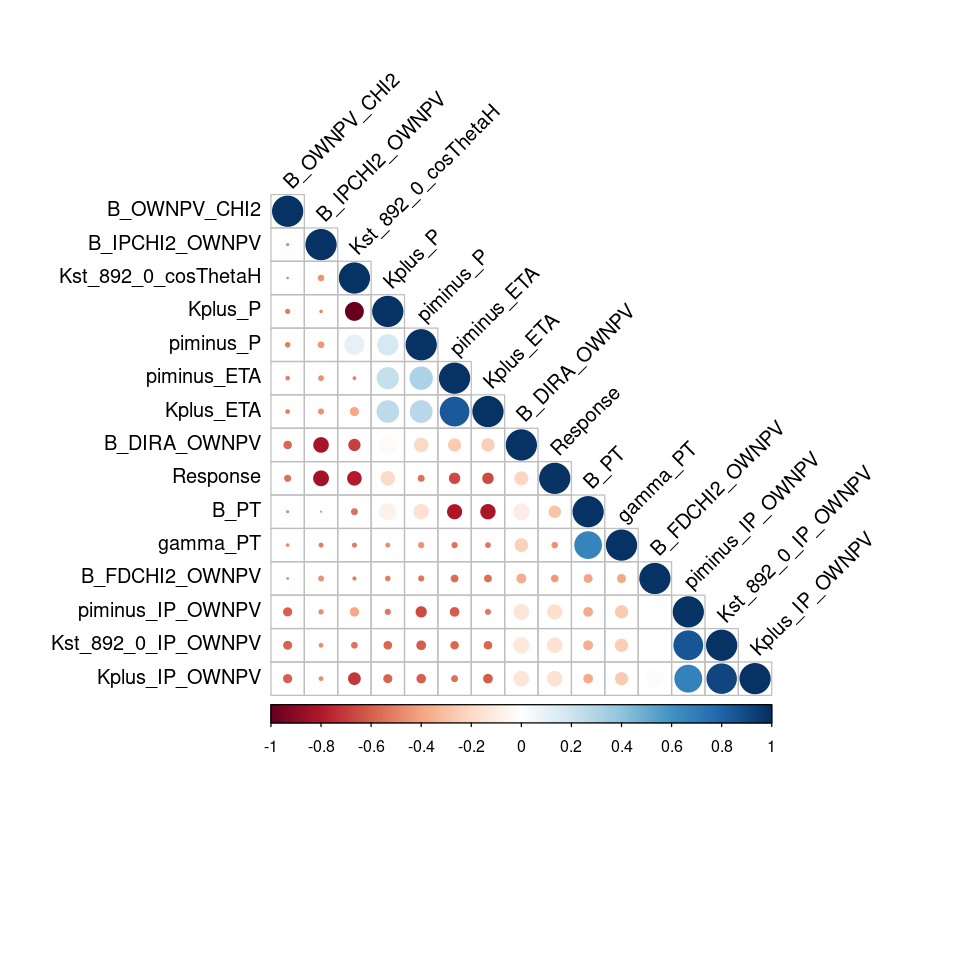

In [42]:
options(repr.plot.width=8,repr.plot.height=8)
corrplot(cor(x.corr), type="lower", order="hclust", tl.col="black", tl.srt=45)

Looks like we have remarkable positive correlation in the pairs **piminus_ETA/Kplus_ETA**, **B_PT/gamma_PT** and the triplet **piminus_IP_OWNPV/Kst_892_0_IP_OWNPV/Kplus_IP_OWNPV**, and negative correlation in the pairs **Kplus_P/Kst_892_0_cosThetaH**, **Kplus_IP_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/B_IPCHI2_OWNPV**, **B_PT/piminus_ETA** and **B_PT/Kplus_ETA**.

Regarding the response, it has strong negative correlation with **Kst_892_0_cosThetaH** and with **B_IPCHI2_OWNPV**.

## 2. Vanilla logistic regression with JAGS

### 2.1. Modelling

As in Week 12's *GLM.01.Logistic.Challenger.ipynb*, we have centered Gaussian priors for the logistic coefficients $\beta_i$, all with $\sigma = 10$, thus precision $\tau = 0.01$ (the same we use in the horseshoe case for $\beta_0$, for the sake of comparison). The likelihood of the logistic regression is, as seen in the mentioned notebook, a Bernoulli distribution with probability $p_i$ given by the logistic function. More graphically:

$$
    \begin{array}{lclcll}
        y_{i}           &\sim    &Bern(p_i),&&&1\leq i\leq n,\\[0.2cm]
         p_i &=      &\operatorname{Logistic}(\eta_i) =\dfrac{\exp(\eta_i)}{1+\exp(\eta_i)},&&&1\leq i\leq n,\\[0.2cm]
        \eta_{i}         &=     &\beta_{0}+x_{i\,\cdot\,}\cdot \beta,\mskip45mu  &&&1\leq i\leq n,\\[0.2cm]
        \beta_{j}        &\sim   &\normaldist(0,1.0E01), &&0\leq j\leq p,\\[0.2cm]
    \end{array}
$$


Define the JAGS model (very similar to what we did with the Challenger data):

In [43]:
model_string<-"
    model {
  
    #Priors
    b0 ~ dnorm(0.0,1.0E-2)
    for (j in 1:n_pars) {
        b[j] ~ dnorm(0.0,1.0E-2)
        }

    # Likelihood
    for (i in 1:n){
        y[i] ~ dbern(p[i])
        #logit(p[i]) <- eta[i]
       
        # logit(p[i]) <- max(-20,min(20,eta[i])) used to avoid numerical instabilities
        p[i] <- 1/(1+exp(-eta[i])) # can use for logit(p[i]) above
        
        eta[i] <- b0 + inprod(b[],X[i,])
        LLi[i] <- y[i] * log(p[i]) + (1 - y[i]) * log(1 - p[i])
    }
    
    # compute loglikelihood, deviance, AIC and BIC
    LogL <- sum(LLi[1:n])
    Deviance <- -2 * LogL            
    AIC <- -2 * LogL + 2 * (n_pars+1)   #total number of params = n_pars+1
    BIC <- -2 * LogL + logn * (n_pars+1)
  }
"

Define parameters and data (this one for each initial subsample), and the corresponding models:

In [44]:
n1<-dim(x0.01)[1]
n2<-dim(x0.02)[1]
n3<-dim(x0.03)[1]

p<-dim(x0.01)[2]
params <- c("b0", "b", "LogL", "AIC", "BIC", "Deviance")

data.01 <- list(y = y.01, X = x0.01, n_pars = p, n = n1, logn=log(n1))
data.02 <- list(y = y.02, X = x0.02, n_pars = p, n = n2, logn=log(n2))
data.03 <- list(y = y.03, X = x0.03, n_pars = p, n = n3, logn=log(n3))


In [45]:
model.01<-jags.model(textConnection(model_string),data=data.01)
model.02<-jags.model(textConnection(model_string),data=data.02)
model.03<-jags.model(textConnection(model_string),data=data.03)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2084
   Unobserved stochastic nodes: 15
   Total graph size: 58386

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2083
   Unobserved stochastic nodes: 15
   Total graph size: 58358

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2086
   Unobserved stochastic nodes: 15
   Total graph size: 58442

Initializing model



Run one chain per model with 20 000 iterations and a burnout of the 5000 (see summary(sample.01)) initial samples (those that will be discarded to assure randomness of MCMC sampling). Note that this takes us around 50 min for each of the three subsamples.

We could have defined initial values for the parameters, but as we have seen in the course JAGS can make a judicious choice thereof from the data, so we let it do it for us.

In [46]:
update(model.01, 4000, progress.bar = "gui")
update(model.02, 4000, progress.bar = "gui")
update(model.03, 4000, progress.bar = "gui")

In [47]:
start.time <- Sys.time()

sample.01<-coda.samples(model.01, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 48.90287 mins

In [48]:
start.time <- Sys.time()

sample.02<-coda.samples(model.02, variable.names = params,
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 50.74733 mins

In [49]:
start.time <- Sys.time()

sample.03<-coda.samples(model.03, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 48.17632 mins

Visualise output:

In [50]:
summary(sample.01)


Iterations = 5001:25000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean      SD  Naive SE Time-series SE
AIC      1052.47783 5.40992 0.0382539      0.1066549
BIC      1137.10850 5.40992 0.0382539      0.1066549
Deviance 1022.47783 5.40992 0.0382539      0.1066549
LogL     -511.23892 2.70496 0.0191270      0.0533274
b[1]        0.24268 0.08347 0.0005903      0.0008013
b[2]       -0.53963 0.08678 0.0006136      0.0009952
b[3]       -0.18603 0.21060 0.0014892      0.0030181
b[4]        0.19587 0.14029 0.0009920      0.0020228
b[5]        1.42849 0.36949 0.0026127      0.0172899
b[6]        0.12949 0.77886 0.0055073      0.0588608
b[7]       -0.68007 0.17004 0.0012023      0.0053778
b[8]        0.94363 0.55801 0.0039457      0.0381415
b[9]        1.49646 0.25656 0.0018142      0.0092098
b[10]       2.15867 0.44348 0.0031359      0.0247234
b[11] 

In [51]:
#summary(sample.02)

In [52]:
#summary(sample.03)

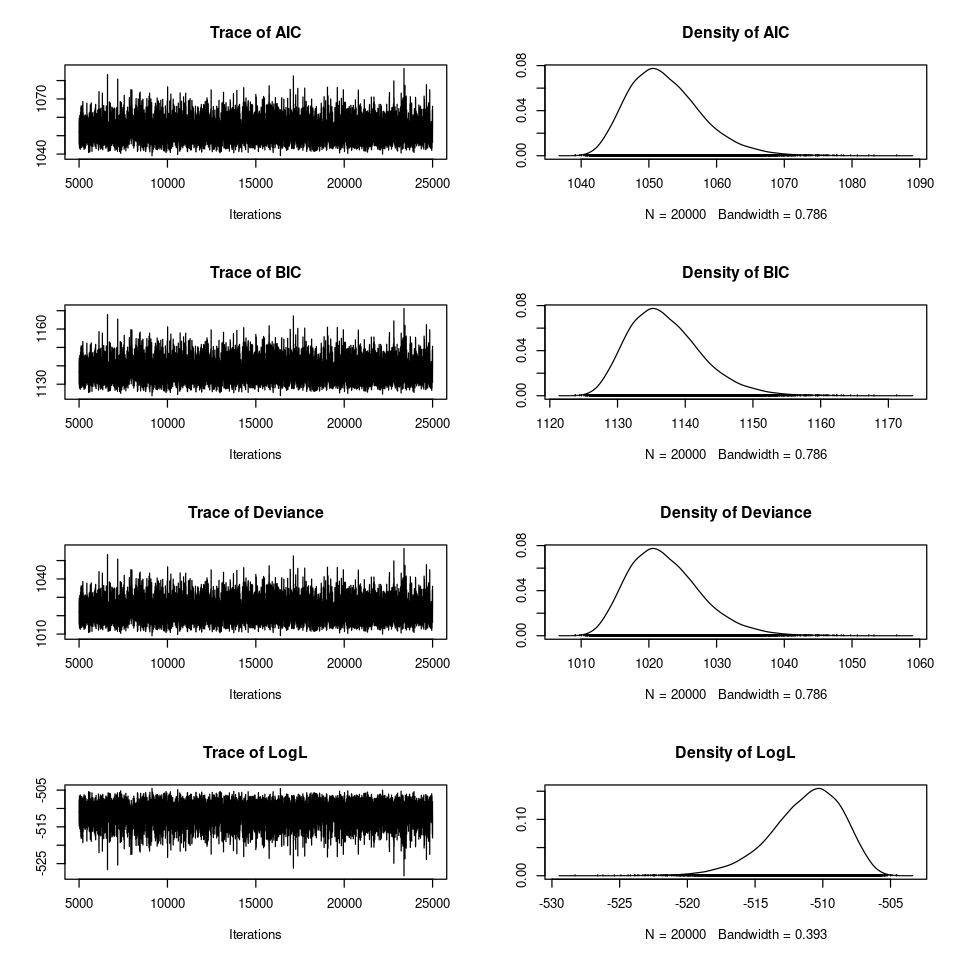

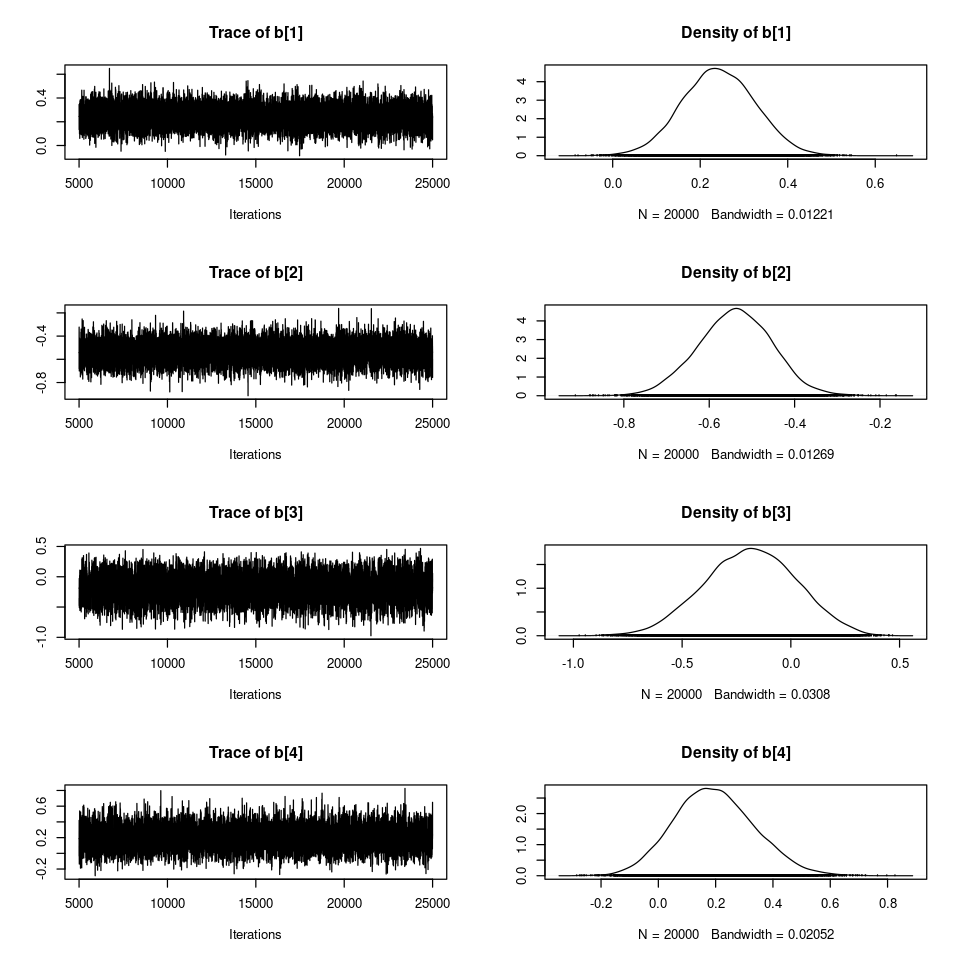

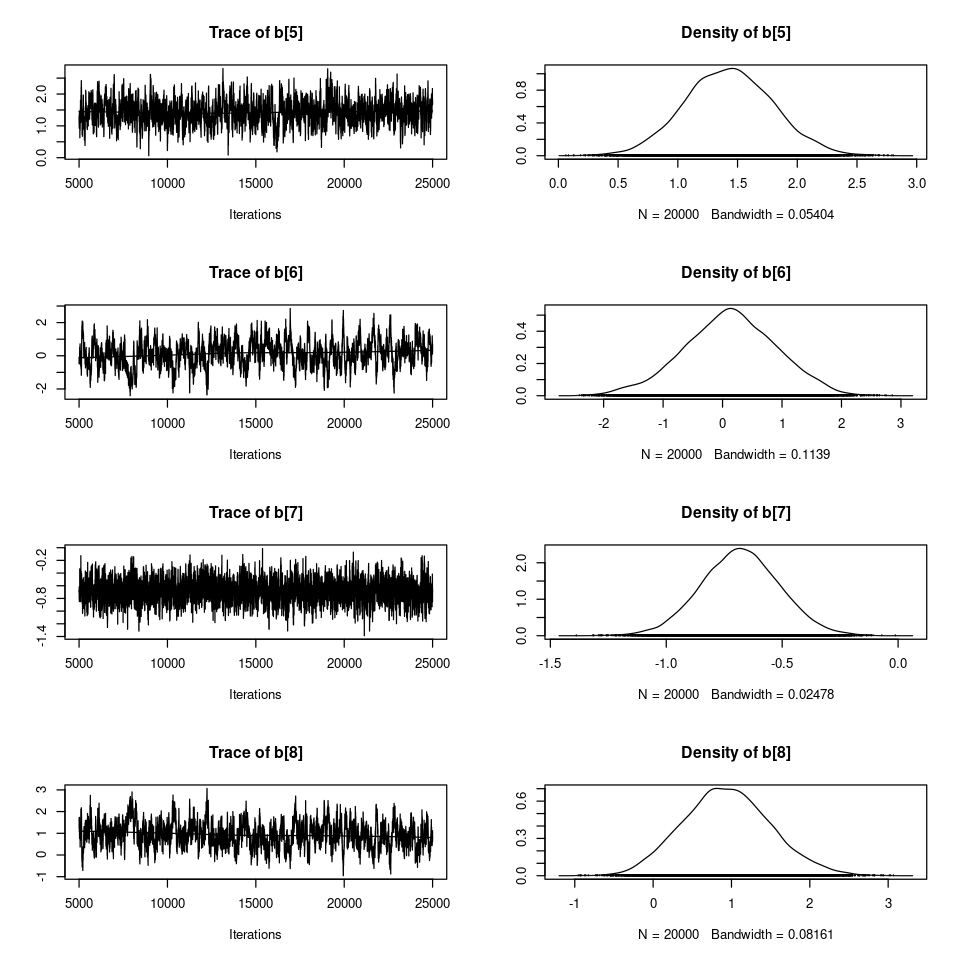

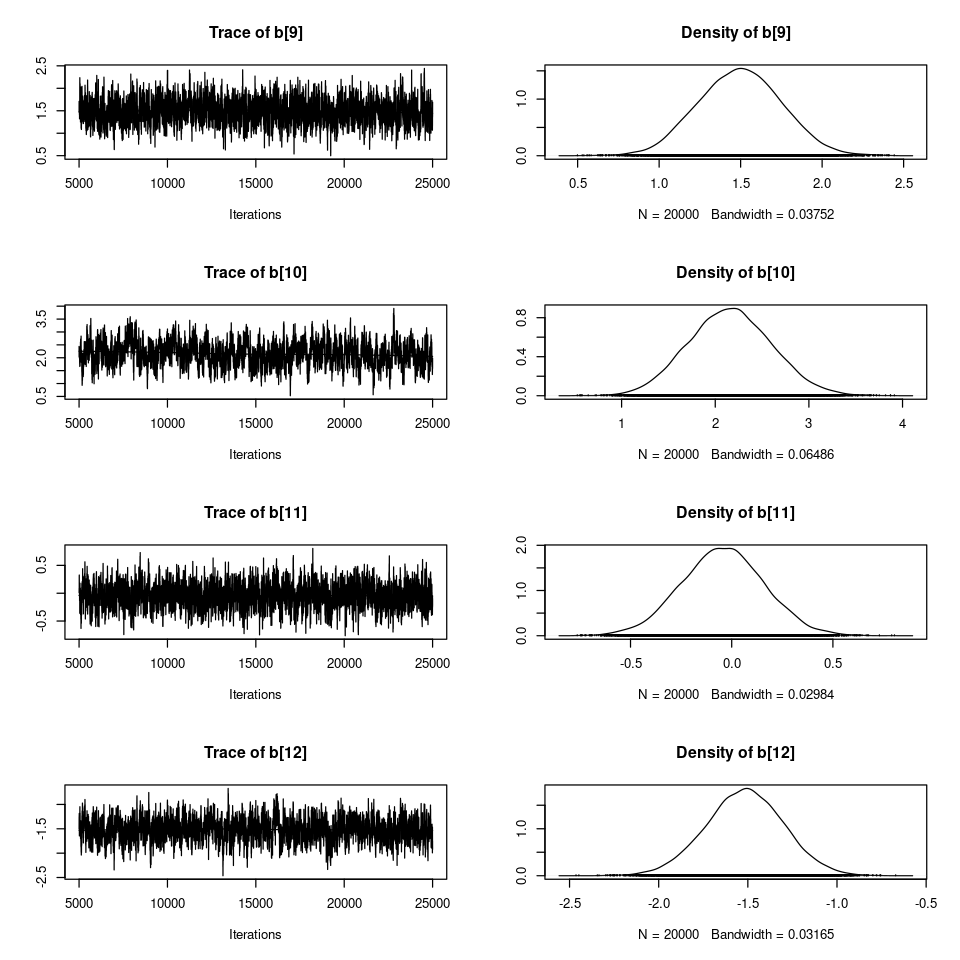

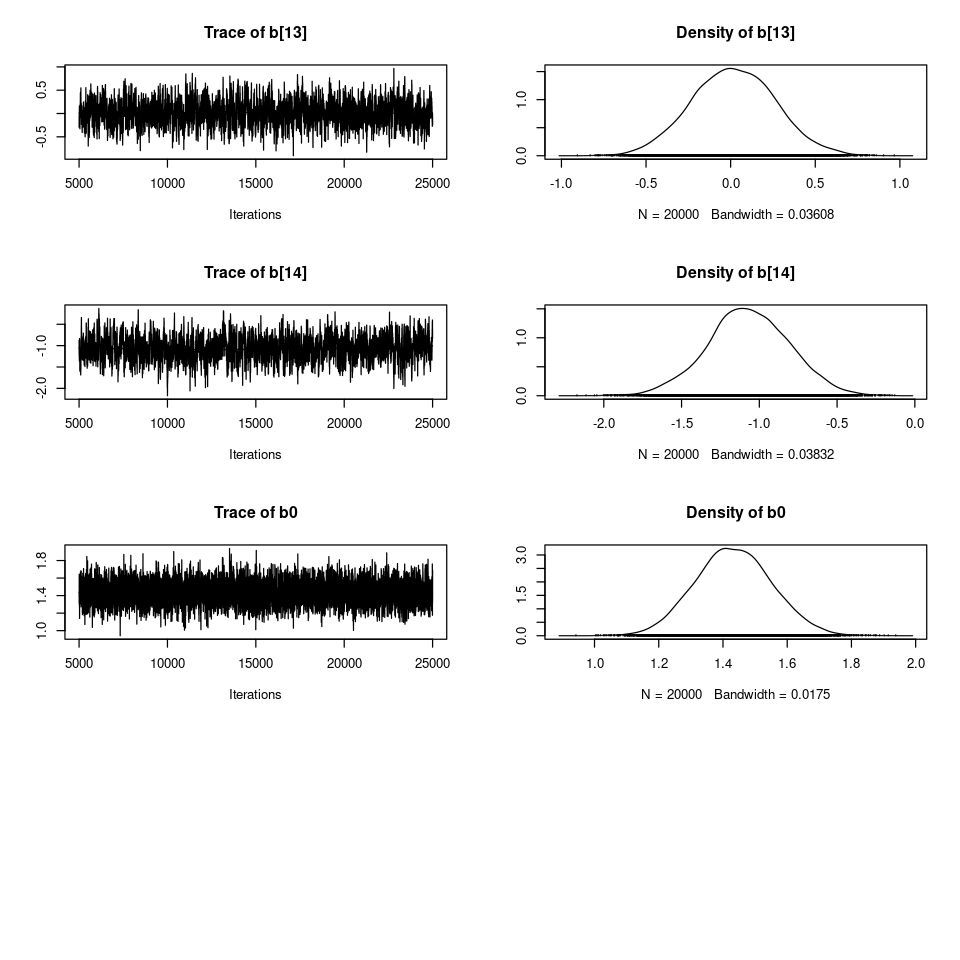

In [53]:
plot(sample.01)

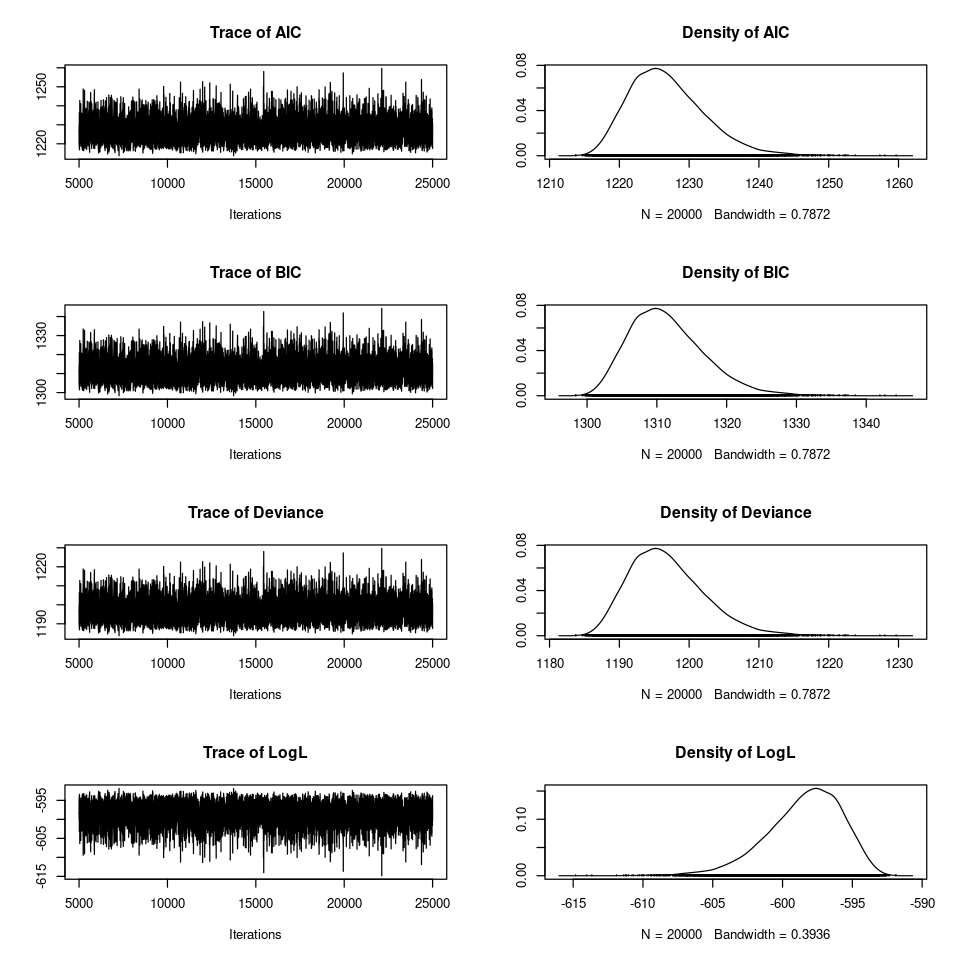

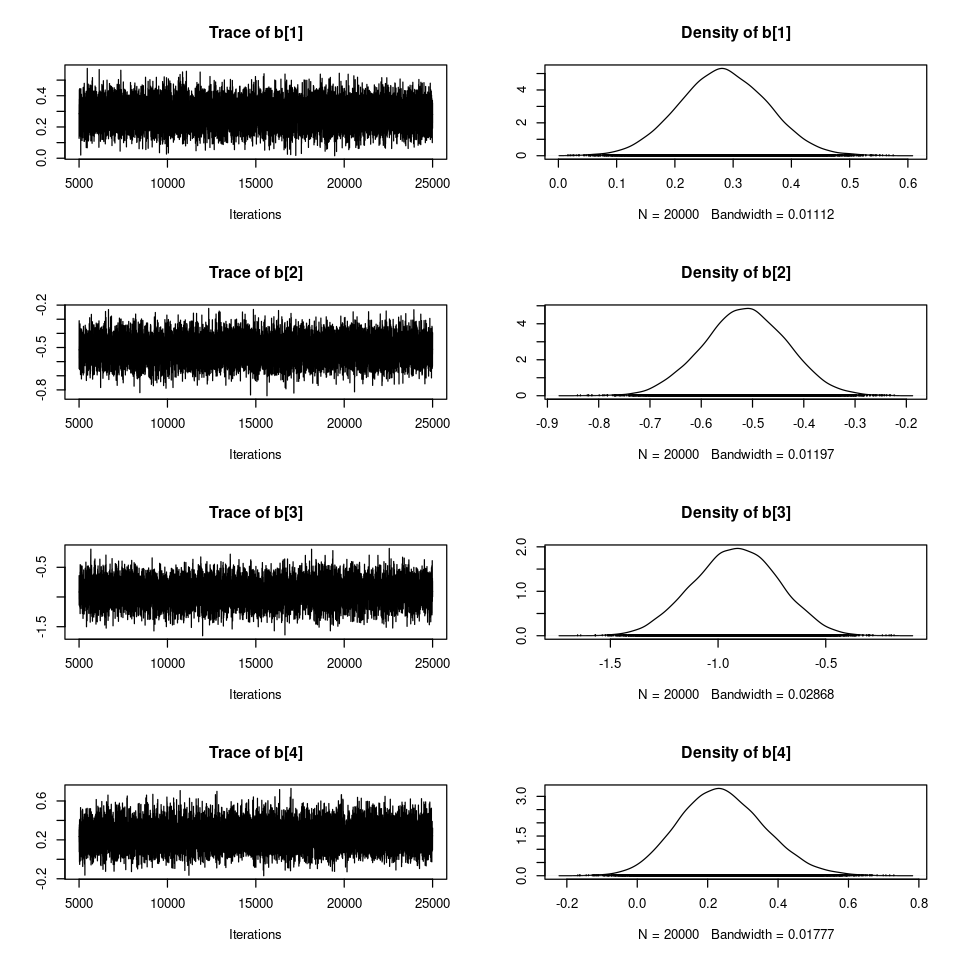

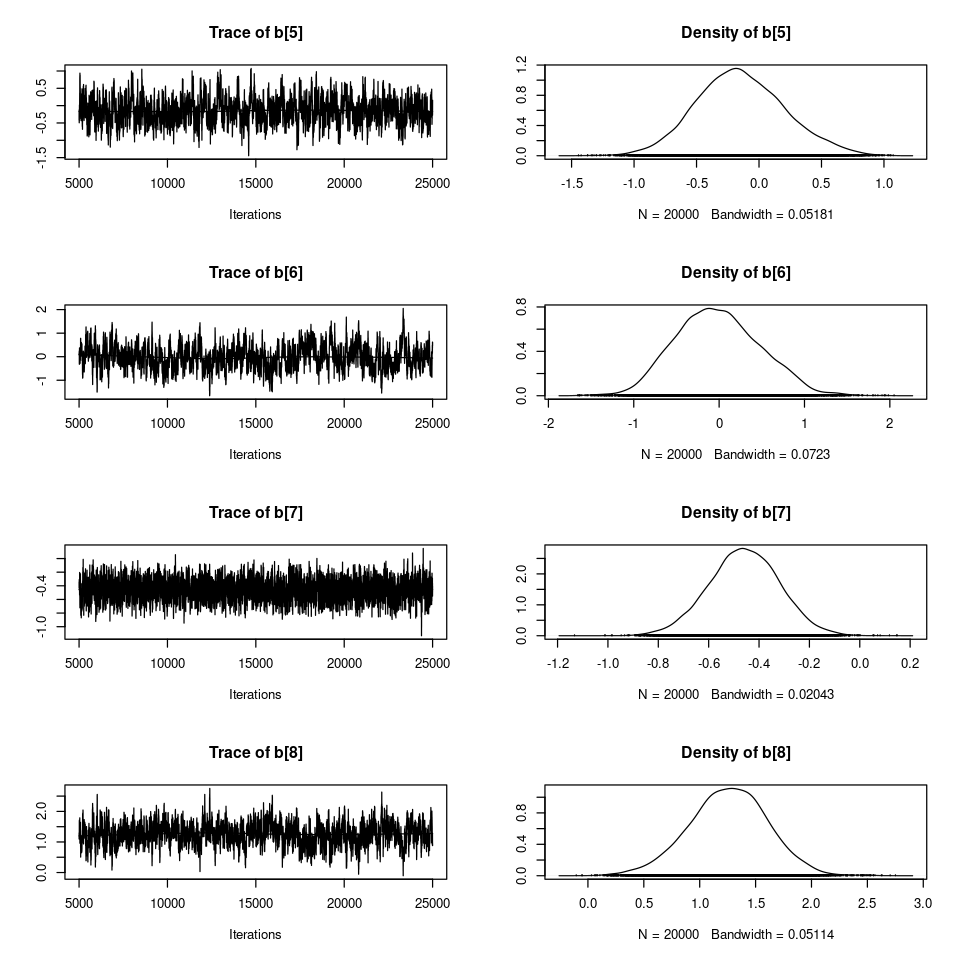

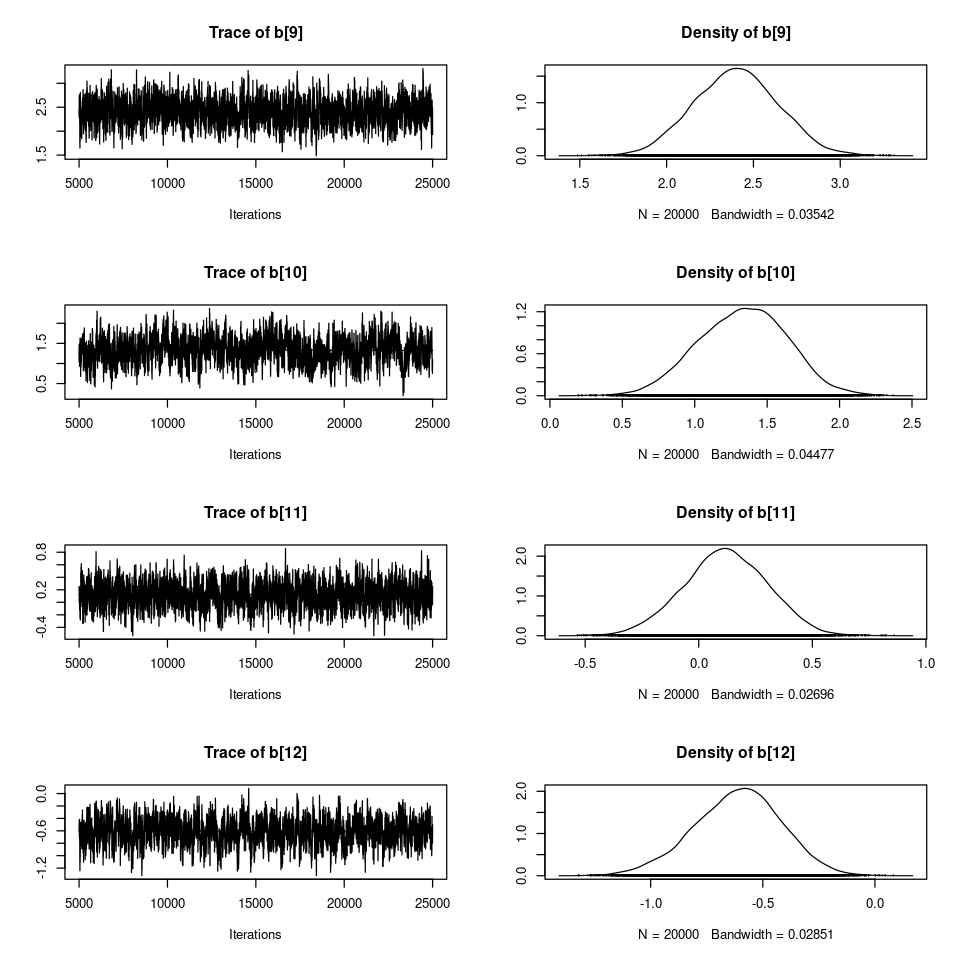

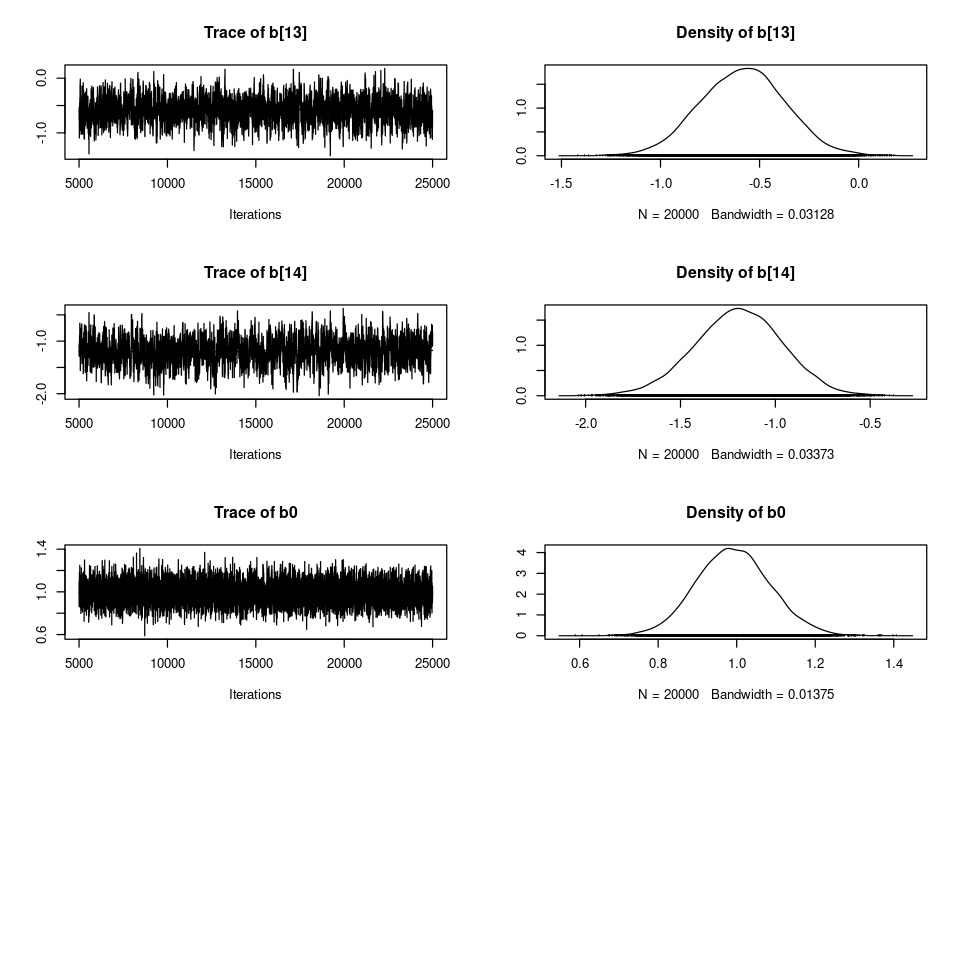

In [54]:
plot(sample.02)

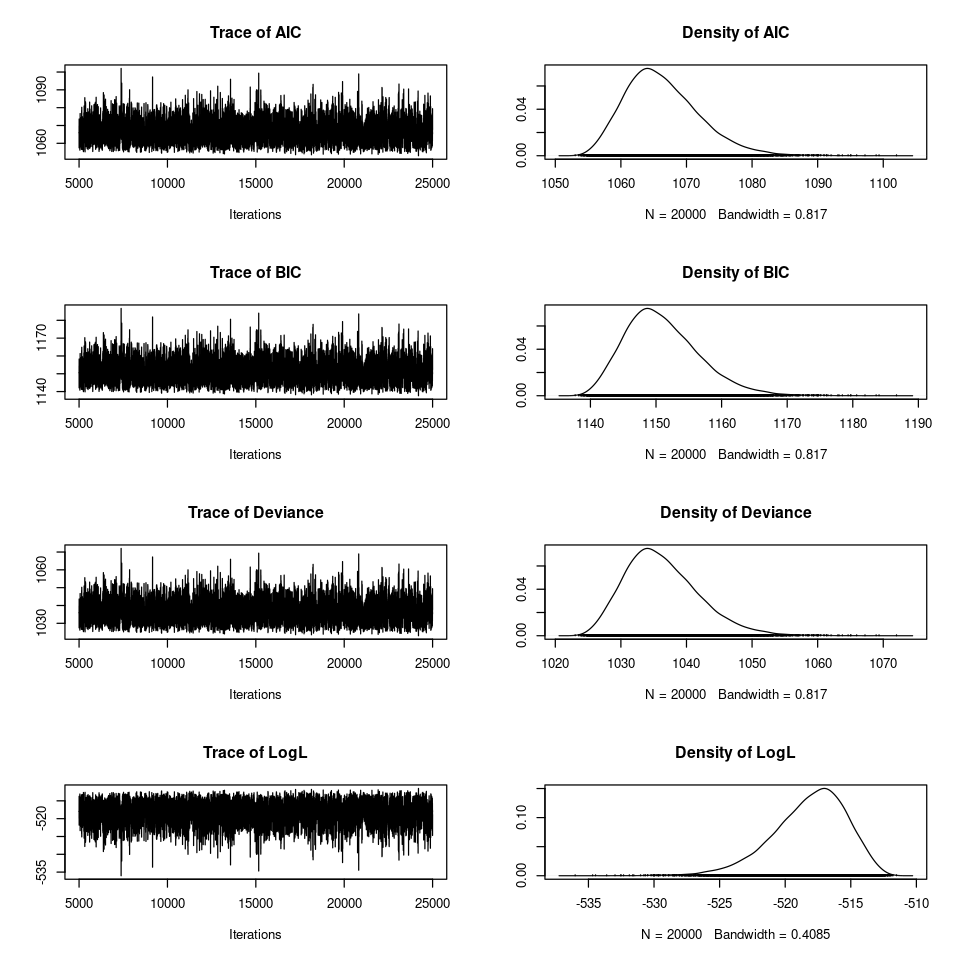

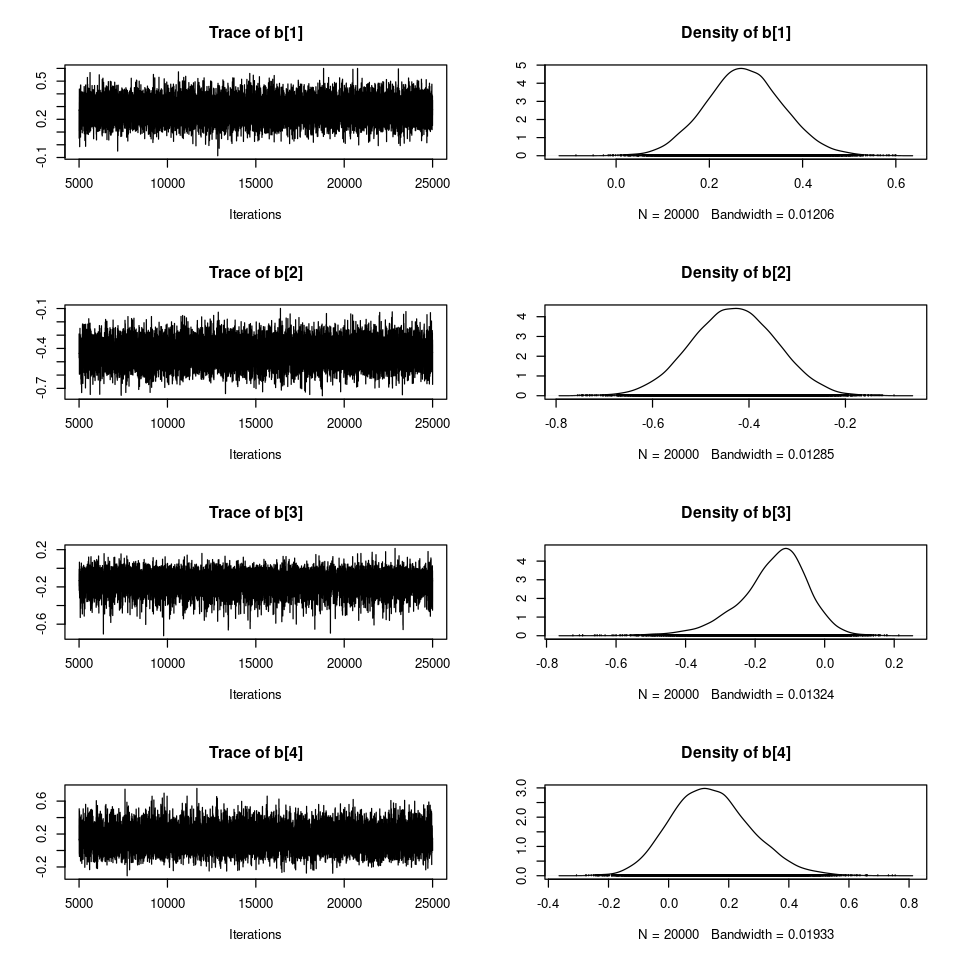

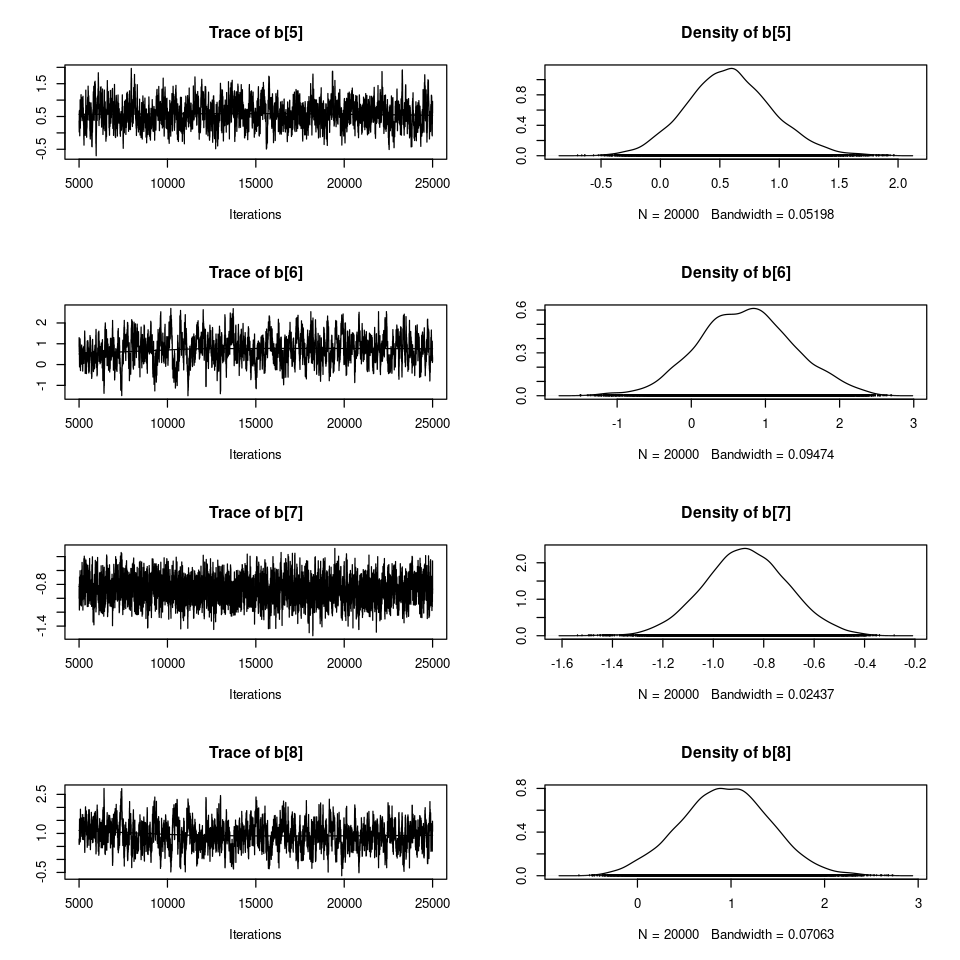

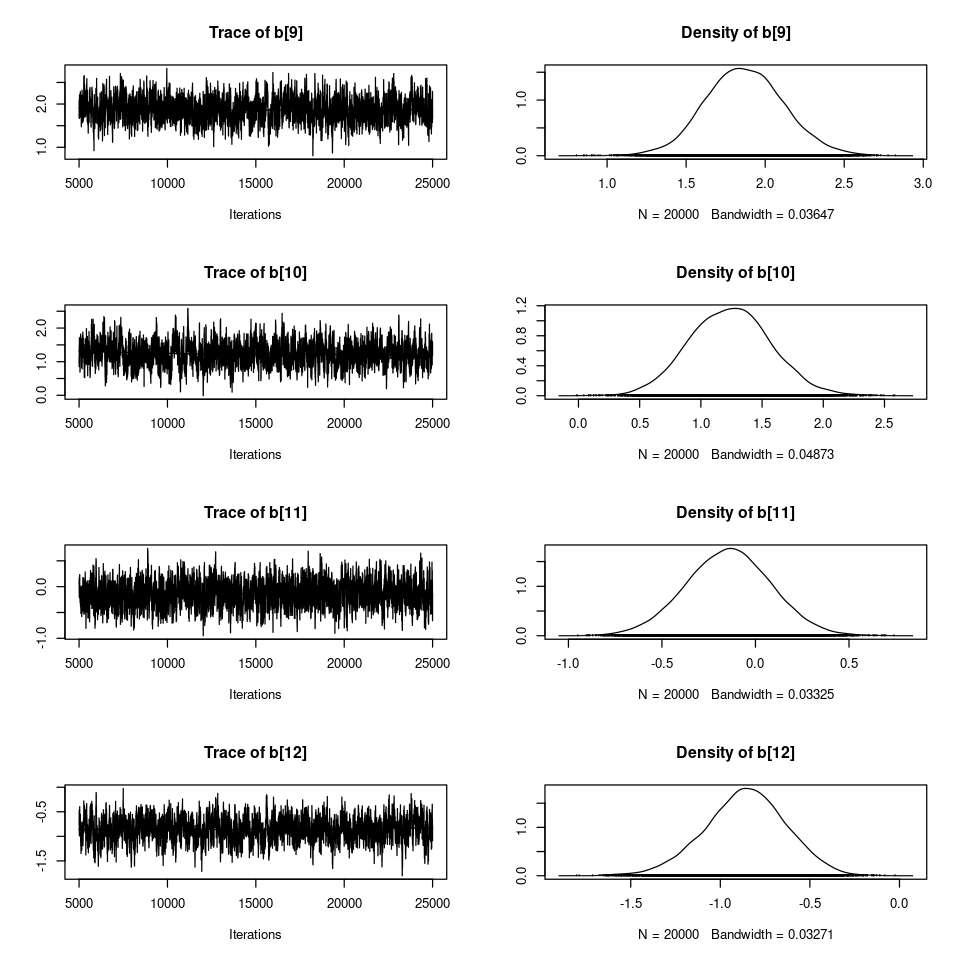

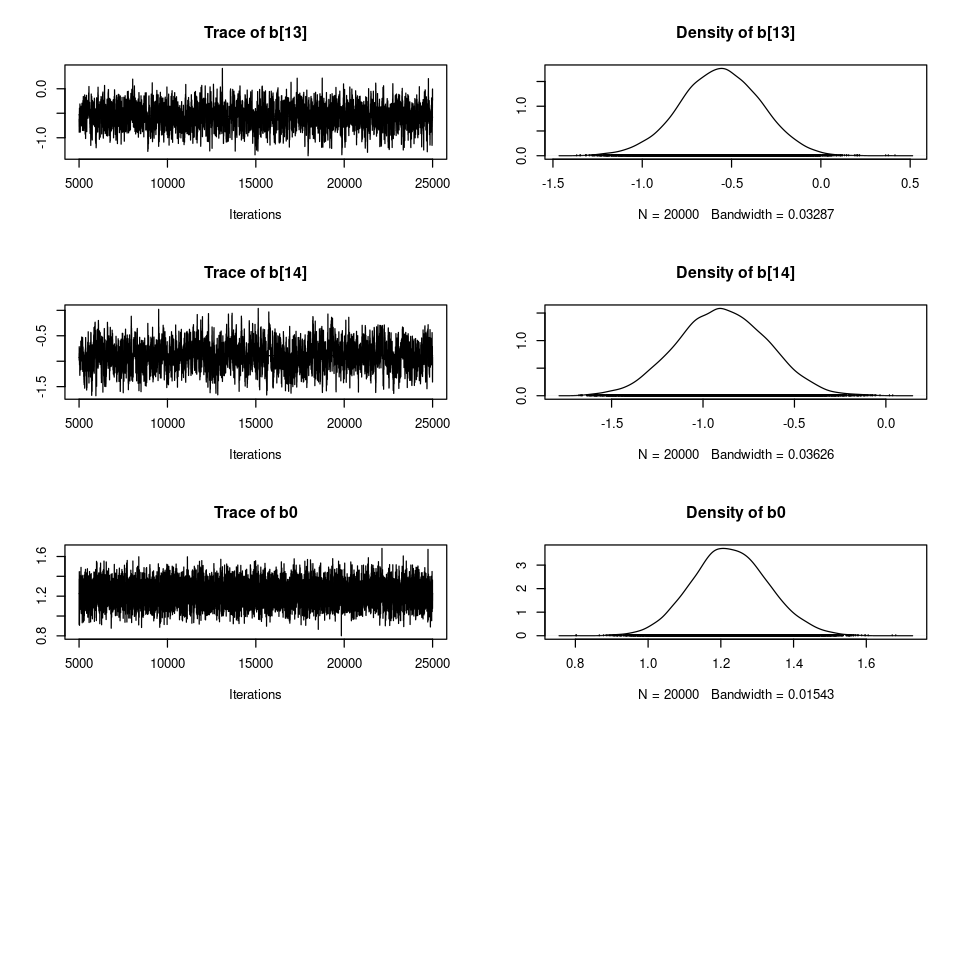

In [55]:
plot(sample.03)

The overall noisy traceplots show that posteriors are correctly sampled.

To check for consistency among initial subsamples, we look at the mean posterior values of the logistic parameters ($\beta_0$ and $\beta$) for each of them. As several times before, we define a function to do it:

In [56]:
logistic.params<-function(sample){
    #retrieve expected values of logistic regression params (the method in 
    # week12/GLM.01.Logistic.Challenger.ipynb does not work here because the 
    #JAGS object is different)
    stats<-summary(sample)$statistics
    a<-stats[19,1]
    b<-c()
    for (i in 5:18){
        b[i-4]<-stats[i,1]
        }
   return(list("b0"=a, "b"=b))
}

In [57]:
logistic.params(sample.01)
logistic.params(sample.02)
logistic.params(sample.03)

$b0
[1] 1.433264

$b
 [1]  0.24267651 -0.53962746 -0.18603346  0.19587198  1.42848862  0.12949150
 [7] -0.68006905  0.94363215  1.49646434  2.15866672 -0.04379384 -1.51801209
[13]  0.01755712 -1.06898507

$b0
[1] 0.9918692

$b
 [1]  0.28338448 -0.51445451 -0.91685130  0.24087964 -0.14483672 -0.01453982
 [7] -0.45912015  1.25633100  2.40079390  1.33241516  0.11844425 -0.61242596
[13] -0.58417991 -1.19378450

$b0
[1] 1.225968

$b
 [1]  0.2748467 -0.4314317 -0.1468981  0.1421307  0.5833921  0.7376306
 [7] -0.8710739  0.9388665  1.8710732  1.2411222 -0.1436373 -0.8599991
[13] -0.5636790 -0.8935561

In [58]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

The posterior means seem, as with OSS, less consistent across subsamples than in the random case, which is puzzling considering an important franction of instances is obtained with the same targetted criterion for each subsample. Although this result may seem unsatisfactor, note that taking a greater subsample size would yield an unreasonable execution time for the notebook. 

### 2.2. Evaluation

To evaluate the model, we consider the train and test deviance, AIC, BIC, AUC and recall, using the same function as in the rest of JAGS notebooks.

Note that for the test we use all samples not included in the corresponding 2000 train subsample, so **we test with about 210 000 samples** each time. We do this to put to use all available information, and we can afford to do so at test because we are just evaluating the logistic function (what took so long at train was the MCMC sampling).

We recall that, in the case of the train phase, we also print the deviance, AIC and BIC computed by JAGS, for reference.

In [59]:
evaluate<-function(sample, x, y, phase, threshold=NULL){
    n<-dim(x)[1]
    n.pars<-dim(x)[2]+1 # includes intercept
    
    #retrieve expected values of logistic regression params (the method in 
    # week12/GLM.01.Logistic.Challenger.ipynb does not work here because the JAGS object is different)
    stats<-summary(sample)$statistics
    a<-stats[19,1]
    b<-c()
    for (i in 5:18){
        b[i-4]<-stats[i,1]
        }
    #probabilities
    eta.bar<-as.numeric(a+b%*%t(x))
    p.bar<-1/(1+exp(-eta.bar))
    #log-likelihood
    logL.hat<-sum(y * log(p.bar) + (1 - y) * log(1 - p.bar))
    #AUC
    roc_obj <- roc(y, p.bar)
    AUC.hat<-auc(roc_obj)
    cat("\n", phase,"AUC:", round(AUC.hat,4)) 
    #deviance
    D.hat<- -2*logL.hat
    cat("\n", phase,"Deviance:", round(D.hat,4))  
    #AIC
    AIC.hat<-D.hat+2*n.pars
    cat("\n", phase,"AIC:", round(AIC.hat,4))  
    #BIC
    BIC.hat<-D.hat+log(n)*n.pars
    cat("\n", phase,"BIC:", round(BIC.hat,4))  
    #if training phase, print JAGS quantities as well for comparison
    if (phase=="train"){
        aic<-stats[1,1]
        bic<-stats[2,1]
        dev<-stats[3,1]
        cat("\n JAGS Deviance:", round(dev,4))  
        cat("\n JAGS AIC:", round(aic,4))  
        cat("\n JAGS BIC:", round(bic,4))   
        #compute threshold and recall/sensitivity for best operating point
        #in train ROC curve, also plotting the curve
        rc <- ROC(test=p.bar, stat = as.logical(y), plot="ROC", main="Train ROC curve") 
        opt <- which.max(rowSums(rc$res[, c("sens", "spec")]))
        # optimal cut-off point and corresponding recall
        threshold = as.numeric(names(opt))
        recall<-rc$res$sens[opt]
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
        return(threshold)
        } else{
        # for true positives, y=1 and p.bar>threshold, so y+p.bar>1+threshold
        check<-y+p.bar 
        true.p<-0
        total.p<-sum(y)
        for (num in check){
            if (num >= (1+threshold)){
            true.p<-true.p+1    
            }
        }
        #print test recall
        recall<-true.p/total.p
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
            
        }
    
    }

We call our function for the result obtained for each original subsample:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.962
 train Deviance: 1007.65
 train AIC: 1037.65
 train BIC: 1122.28
 JAGS Deviance: 1022.478
 JAGS AIC: 1052.478
 JAGS BIC: 1137.109
 train recall/sensitivity 0.9504

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7532
 test Deviance: 506531.9
 test AIC: 506561.9
 test BIC: 506715.8
 test recall/sensitivity 0.8654

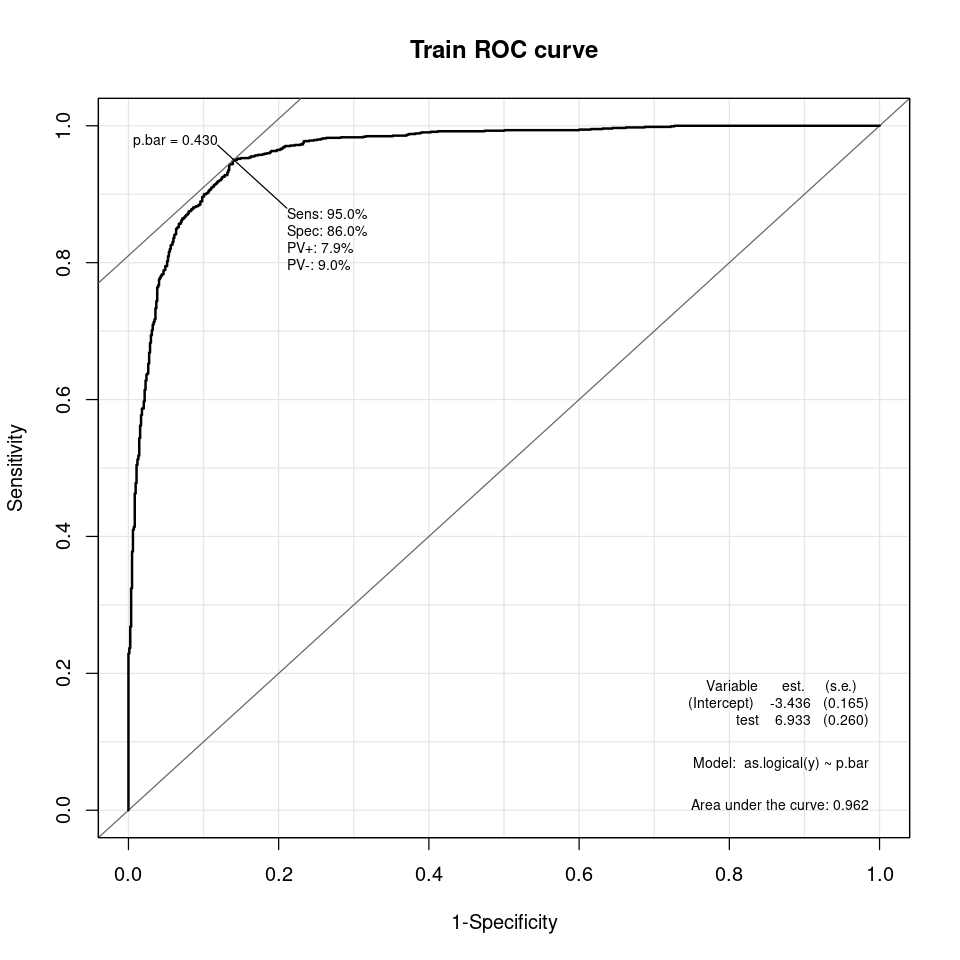

In [60]:
#evaluate train
thr<-evaluate(sample.01, x0.01, y.01, phase="train")
# evaluate test
xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.948
 train Deviance: 1182.295
 train AIC: 1212.295
 train BIC: 1296.918
 JAGS Deviance: 1196.874
 JAGS AIC: 1226.874
 JAGS BIC: 1311.497
 train recall/sensitivity 0.9239

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7625
 test Deviance: 428612.2
 test AIC: 428642.2
 test BIC: 428796.1
 test recall/sensitivity 0.8183

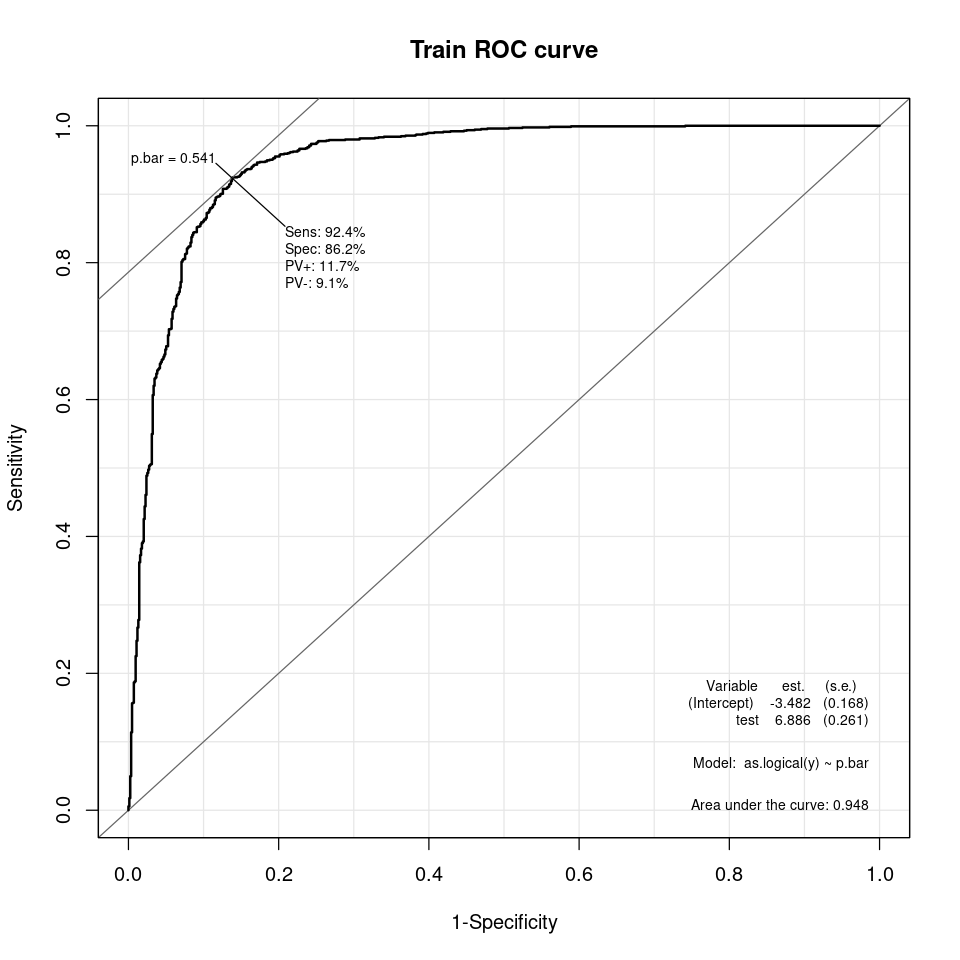

In [61]:
thr<-evaluate(sample.02, x0.02, y.02, phase="train")

xt<-model.matrix(Response~.,test.02)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.02$Response
evaluate(sample.02, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.9611
 train Deviance: 1021.195
 train AIC: 1051.195
 train BIC: 1135.84
 JAGS Deviance: 1036.331
 JAGS AIC: 1066.331
 JAGS BIC: 1150.976
 train recall/sensitivity 0.9225

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7553
 test Deviance: 479528.7
 test AIC: 479558.7
 test BIC: 479712.6
 test recall/sensitivity 0.8227

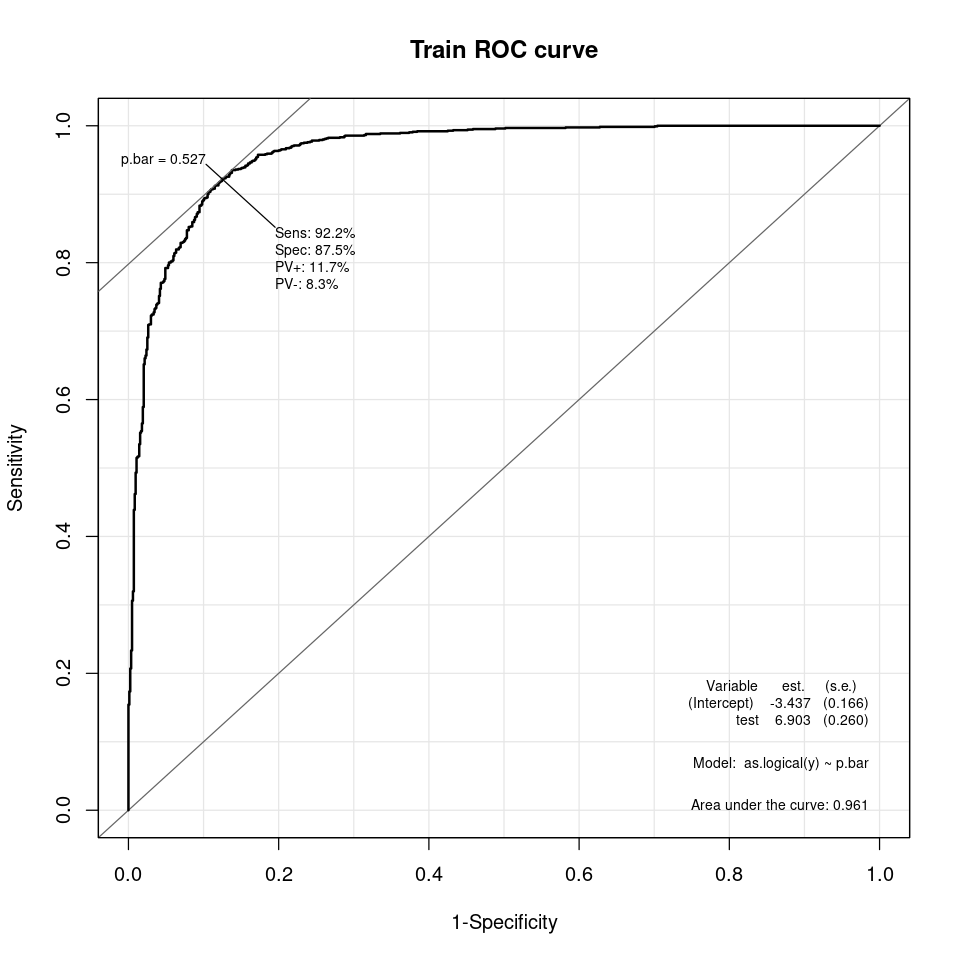

In [62]:
thr<-evaluate(sample.03, x0.03, y.03, phase="train")

xt<-model.matrix(Response~.,test.03)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.03$Response
evaluate(sample.03, xt, yt, phase="test", threshold = thr)

The overfitting in AUC is here evident, worse than with OSS: at train it is close to 100% (as shown also by the ROC curves), while at test it reaches at most 0.76 (a poor result compared to that of the random undersampling). Recall is better, with test values ranging from 0.82 to 0.87. 

The above results corroborate our interpretation in **CERN-OssSamples-Logistic-JAGS.ipynb#**: seems our RTR method is actually distorting the boundary, not capturing it. The improvement in recall fits our explanation for the same effect with OSS: that it is a consequence of the positive imbalance of the subsamples.


## 3. Conclusion

The results for the NCR seem to confirm (to our chagrin) the insterpretation given to the OSS case: the RTR method is too harsh on the real boundary, at least in the case studied here. On the other hand, the one-step targetted removal we tried in **CERN-MinTargSamples-Logistic-JAGS.ipynb** seems ineffective for our problem.

This is not so surprising given the magnitude of the dataset reduction we required: both one-step and recurrent targetted removal (especially the first) should give better results if we could handle greater subsample sizes.

In any case, regardless of the final worth of the RTR method itself, its development and implementation in this project have provided what we consider valuable insight, namely as to the complexity of imbalance problems in general (as we have seen it is far from trivial to account for imbalance) and the potential use of inducing imbalance in favour of the class of interest.